Let's make sure that we have access to GPU. We can use nvidia-smi command to do that. In case of any problems navigate to Edit -> Notebook settings -> Hardware accelerator, set it to GPU, and then click Save.

In [ ]:
!nvidia-smi

Thu Aug  7 10:32:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8 via Ultralytics and other necessary libraries

In [ ]:
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.175 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 43.3/112.6 GB disk)


## Inference

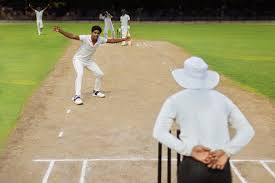

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename='/content/images.jpeg', width=600)

# Load Model

In [ ]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolov8m.pt')
image = Image.open('/content/images.jpeg')
result = model.predict(image, conf=0.25)[0]


0: 448x640 5 persons, 53.6ms
Speed: 31.8ms preprocess, 53.6ms inference, 376.3ms postprocess per image at shape (1, 3, 448, 640)


**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [ ]:
result.boxes.xyxy

tensor([[ 51.7378,  24.3399, 131.4835, 105.4820],
        [152.0274,  55.5957, 255.4615, 180.6152],
        [101.9182,  10.3019, 115.6104,  39.4111],
        [119.5330,   8.9403, 131.6293,  46.5651],
        [ 28.4062,   2.5306,  49.7676,  36.0994]], device='cuda:0')

In [ ]:
result.boxes.conf

tensor([0.9434, 0.9290, 0.6853, 0.5344, 0.3416], device='cuda:0')

In [ ]:
result.boxes.cls

tensor([0., 0., 0., 0., 0.], device='cuda:0')

In [ ]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

In [ ]:
detections

Detections(xyxy=array([[     51.738,       24.34,      131.48,      105.48],
       [     152.03,      55.596,      255.46,      180.62],
       [     101.92,      10.302,      115.61,      39.411],
       [     119.53,      8.9403,      131.63,      46.565],
       [     28.406,      2.5306,      49.768,      36.099]], dtype=float32), mask=None, confidence=array([    0.94343,     0.92898,     0.68533,     0.53438,      0.3416], dtype=float32), class_id=array([0, 0, 0, 0, 0]), tracker_id=None, data={'class_name': array(['person', 'person', 'person', 'person', 'person'], dtype='<U6')}, metadata={})

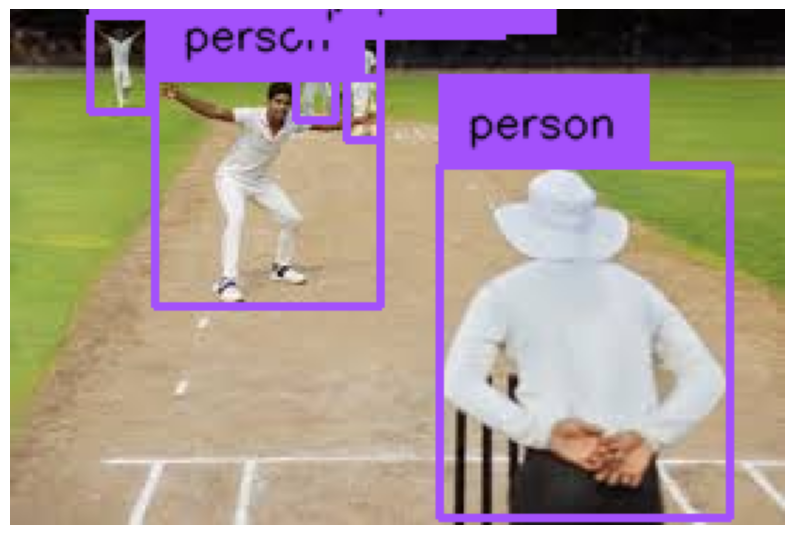

In [ ]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Fine-tune YOLOv8m on custom dataset

In [ ]:
# Following code snippet provide by Roboflow

# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="kYxB4afXAzgjb4JvPe6R")
# project = rf.workspace("robo-computer-vision").project("cricket_object_detection-dzequ")
# version = project.version(1)
# dataset = version.download("yolov8")

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("robo-computer-vision").project("cricket_object_detection-dzequ")
version = project.version(1)
dataset = version.download("yolov8")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to cricket_object_detection-1 in yolov8:: 100%|██████████| 4807/4807 [00:00<00:00, 5544.65it/s]


## Custom Training

In [ ]:
dataset.location

'/content/datasets/cricket_object_detection-1'

In [ ]:
%cd {HOME}

/content


In [ ]:
# Path to the downloaded Roboflow dataset yaml file
data_yaml_path = os.path.join(dataset.location, "data.yaml")

# Load the model (YOLOv8 medium here, can switch to 'yolov8n.pt' for faster training)
model = YOLO("yolov8m.pt")

# Train the model
results = model.train(
    data=data_yaml_path,
    epochs=50,
    batch=16,
    imgsz=640,
    plots=True,
    device=0  # uses GPU id 0; automatically defaults to GPU if available
)

Ultralytics 8.3.175 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/cricket_object_detection-1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True

Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

 19                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  2   4207104  ultralytics.nn.modules.block.C2f             [960, 576, 2]                 
 22        [15, 18, 21]  1   3779749  ultralytics.nn.modules.head.Detect           [7, [192, 384, 576]]          
Model summary: 169 layers, 25,860,373 parameters, 25,860,357 gradients, 79.1 GFLOPs

Transferred 469/475 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1850.6±660.8 MB/s, size: 70.6 KB)


train: Scanning /content/datasets/cricket_object_detection-1/train/labels... 2275 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2275/2275 [00:01<00:00, 2090.29it/s]

train: New cache created: /content/datasets/cricket_object_detection-1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 559.4±447.4 MB/s, size: 57.2 KB)


val: Scanning /content/datasets/cricket_object_detection-1/valid/labels... 72 images, 0 backgrounds, 0 corrupt: 100%|██████████| 72/72 [00:00<00:00, 1903.08it/s]

val: New cache created: /content/datasets/cricket_object_detection-1/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.29G      1.294      1.488      1.285         39        640: 100%|██████████| 143/143 [01:18<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         72        431      0.817      0.804      0.842      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.49G      1.143     0.9237      1.217         32        640: 100%|██████████| 143/143 [01:15<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

                   all         72        431      0.713      0.677      0.744      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       6.4G      1.143     0.8731      1.223         15        640: 100%|██████████| 143/143 [01:14<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all         72        431      0.658      0.669      0.693      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.46G      1.102     0.8221      1.202         16        640: 100%|██████████| 143/143 [01:14<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]

                   all         72        431      0.793      0.683      0.766      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.45G      1.072     0.7675      1.179         38        640: 100%|██████████| 143/143 [01:13<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

                   all         72        431      0.827      0.808      0.839      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       6.5G      1.032     0.7354      1.154         28        640: 100%|██████████| 143/143 [01:14<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]

                   all         72        431      0.884      0.876      0.902      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.34G      1.015     0.7033       1.15         27        640: 100%|██████████| 143/143 [01:14<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         72        431       0.89      0.837      0.893      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       6.5G     0.9951     0.6678      1.134         24        640: 100%|██████████| 143/143 [01:14<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         72        431      0.891      0.871      0.911      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.39G     0.9824     0.6489      1.127         24        640: 100%|██████████| 143/143 [01:14<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         72        431      0.902       0.88      0.923      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.42G     0.9613     0.6199      1.114         34        640: 100%|██████████| 143/143 [01:14<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

                   all         72        431      0.856      0.884      0.913      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.43G     0.9408     0.6044      1.103         21        640: 100%|██████████| 143/143 [01:14<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         72        431      0.896      0.889      0.927      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.48G     0.9245     0.5843      1.096         28        640: 100%|██████████| 143/143 [01:14<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]

                   all         72        431      0.929      0.894      0.941      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.42G     0.9152       0.58       1.09         35        640: 100%|██████████| 143/143 [01:14<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all         72        431      0.914      0.904      0.944      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       6.5G       0.89     0.5693      1.079         10        640: 100%|██████████| 143/143 [01:14<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]

                   all         72        431      0.863      0.893       0.92      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.39G     0.8924      0.552      1.074         29        640: 100%|██████████| 143/143 [01:14<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


                   all         72        431      0.917       0.89      0.937      0.667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.43G     0.8749     0.5423      1.066         14        640: 100%|██████████| 143/143 [01:14<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


                   all         72        431      0.899       0.88      0.935      0.659

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.46G     0.8672     0.5248      1.061         19        640: 100%|██████████| 143/143 [01:14<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                   all         72        431      0.911      0.901       0.94      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.51G     0.8497       0.52      1.056         24        640: 100%|██████████| 143/143 [01:14<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

                   all         72        431      0.903      0.925       0.94      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.39G     0.8454     0.5137      1.056         29        640: 100%|██████████| 143/143 [01:14<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

                   all         72        431      0.912      0.918      0.939      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.46G     0.8353     0.5038      1.048         28        640: 100%|██████████| 143/143 [01:14<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

                   all         72        431      0.922      0.917       0.94      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.44G      0.822     0.4857      1.037         30        640: 100%|██████████| 143/143 [01:14<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         72        431      0.916      0.908      0.935      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.49G     0.8279     0.4912       1.04         23        640: 100%|██████████| 143/143 [01:14<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         72        431      0.931      0.918      0.949      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       6.4G     0.8119     0.4771      1.033         35        640: 100%|██████████| 143/143 [01:14<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

                   all         72        431      0.936      0.905      0.947      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.47G     0.7959      0.469      1.028         41        640: 100%|██████████| 143/143 [01:13<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]

                   all         72        431      0.908      0.908       0.94        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.47G     0.7892     0.4588      1.019         30        640: 100%|██████████| 143/143 [01:14<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

                   all         72        431      0.933      0.922      0.951      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.49G     0.7806      0.454      1.019         29        640: 100%|██████████| 143/143 [01:14<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         72        431       0.94      0.903      0.946      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.38G     0.7782     0.4466      1.015         27        640: 100%|██████████| 143/143 [01:13<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]

                   all         72        431      0.917      0.926      0.952      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.46G     0.7686     0.4443       1.01         52        640: 100%|██████████| 143/143 [01:14<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]

                   all         72        431      0.934      0.897      0.941      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.45G     0.7505     0.4323      1.004         14        640: 100%|██████████| 143/143 [01:14<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         72        431      0.929      0.917      0.945      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.48G     0.7487     0.4267     0.9986         51        640: 100%|██████████| 143/143 [01:14<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


                   all         72        431      0.931      0.942      0.957      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.38G     0.7476     0.4277      1.004         21        640: 100%|██████████| 143/143 [01:14<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

                   all         72        431      0.911      0.923      0.936        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.47G      0.739     0.4198      0.995         29        640: 100%|██████████| 143/143 [01:14<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all         72        431      0.929       0.89      0.942      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.47G     0.7212     0.4103     0.9887         50        640: 100%|██████████| 143/143 [01:14<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all         72        431      0.952      0.881      0.951       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       6.5G      0.727     0.4086     0.9911         15        640: 100%|██████████| 143/143 [01:15<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         72        431      0.934      0.922      0.951      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.41G      0.705     0.3953     0.9851          5        640: 100%|██████████| 143/143 [01:14<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]

                   all         72        431      0.947      0.894      0.949      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       6.5G     0.7016     0.3959     0.9854         24        640: 100%|██████████| 143/143 [01:14<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all         72        431      0.923      0.929      0.948      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.38G     0.6995     0.3908     0.9767         24        640: 100%|██████████| 143/143 [01:14<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

                   all         72        431      0.947      0.908      0.946      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.49G     0.6927     0.3877     0.9766         16        640: 100%|██████████| 143/143 [01:14<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

                   all         72        431      0.952      0.933       0.96      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       6.3G     0.6797     0.3793     0.9706         35        640: 100%|██████████| 143/143 [01:13<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]

                   all         72        431      0.949      0.932      0.951      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.49G     0.6675     0.3716     0.9691         31        640: 100%|██████████| 143/143 [01:14<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

                   all         72        431      0.947       0.93      0.952      0.712


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       6.4G     0.6266     0.3265     0.9481         17        640: 100%|██████████| 143/143 [01:14<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         72        431      0.962      0.908      0.951      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       6.4G     0.6055     0.3154      0.934         20        640: 100%|██████████| 143/143 [01:13<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all         72        431      0.954      0.916      0.942      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.32G     0.5924     0.3053     0.9281         18        640: 100%|██████████| 143/143 [01:13<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         72        431       0.94      0.928      0.951      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.39G      0.582     0.3005     0.9249         21        640: 100%|██████████| 143/143 [01:13<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]

                   all         72        431      0.966      0.907      0.962      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       6.4G     0.5723     0.2952     0.9169         18        640: 100%|██████████| 143/143 [01:13<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]

                   all         72        431       0.96      0.923       0.95      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.41G     0.5667     0.2892     0.9165         18        640: 100%|██████████| 143/143 [01:13<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         72        431      0.952       0.92      0.943      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.31G     0.5527     0.2855     0.9099         18        640: 100%|██████████| 143/143 [01:13<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

                   all         72        431      0.948      0.933      0.949      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       6.4G     0.5425      0.281     0.9037         20        640: 100%|██████████| 143/143 [01:13<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         72        431      0.943      0.938      0.956      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.38G     0.5409     0.2765     0.9041         20        640: 100%|██████████| 143/143 [01:13<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

                   all         72        431      0.954      0.941      0.959      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       6.4G     0.5297     0.2751     0.9014         22        640: 100%|██████████| 143/143 [01:13<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]

                   all         72        431      0.954      0.944       0.96      0.736



50 epochs completed in 1.093 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.175 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,843,813 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


                   all         72        431      0.954      0.944       0.96      0.736
                  ball         17         17          1      0.758      0.852      0.377
                   bat         66         74      0.939      0.946      0.956      0.538
               batsman         71        107       0.99          1      0.995      0.899
                bowler         31         31       0.88      0.968      0.978      0.845
                player         58         70      0.959      0.996      0.988      0.857
                stumps         62         68      0.929      0.941      0.954      0.726
                umpire         61         64      0.981          1      0.995      0.909
Speed: 0.3ms preprocess, 10.0ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/train


In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml			 labels.jpg	      train_batch5722.jpg
BoxF1_curve.png			 results.csv	      val_batch0_labels.jpg
BoxP_curve.png			 results.png	      val_batch0_pred.jpg
BoxPR_curve.png			 train_batch0.jpg     val_batch1_labels.jpg
BoxR_curve.png			 train_batch1.jpg     val_batch1_pred.jpg
confusion_matrix_normalized.png  train_batch2.jpg     val_batch2_labels.jpg
confusion_matrix.png		 train_batch5720.jpg  val_batch2_pred.jpg
labels_correlogram.jpg		 train_batch5721.jpg  weights


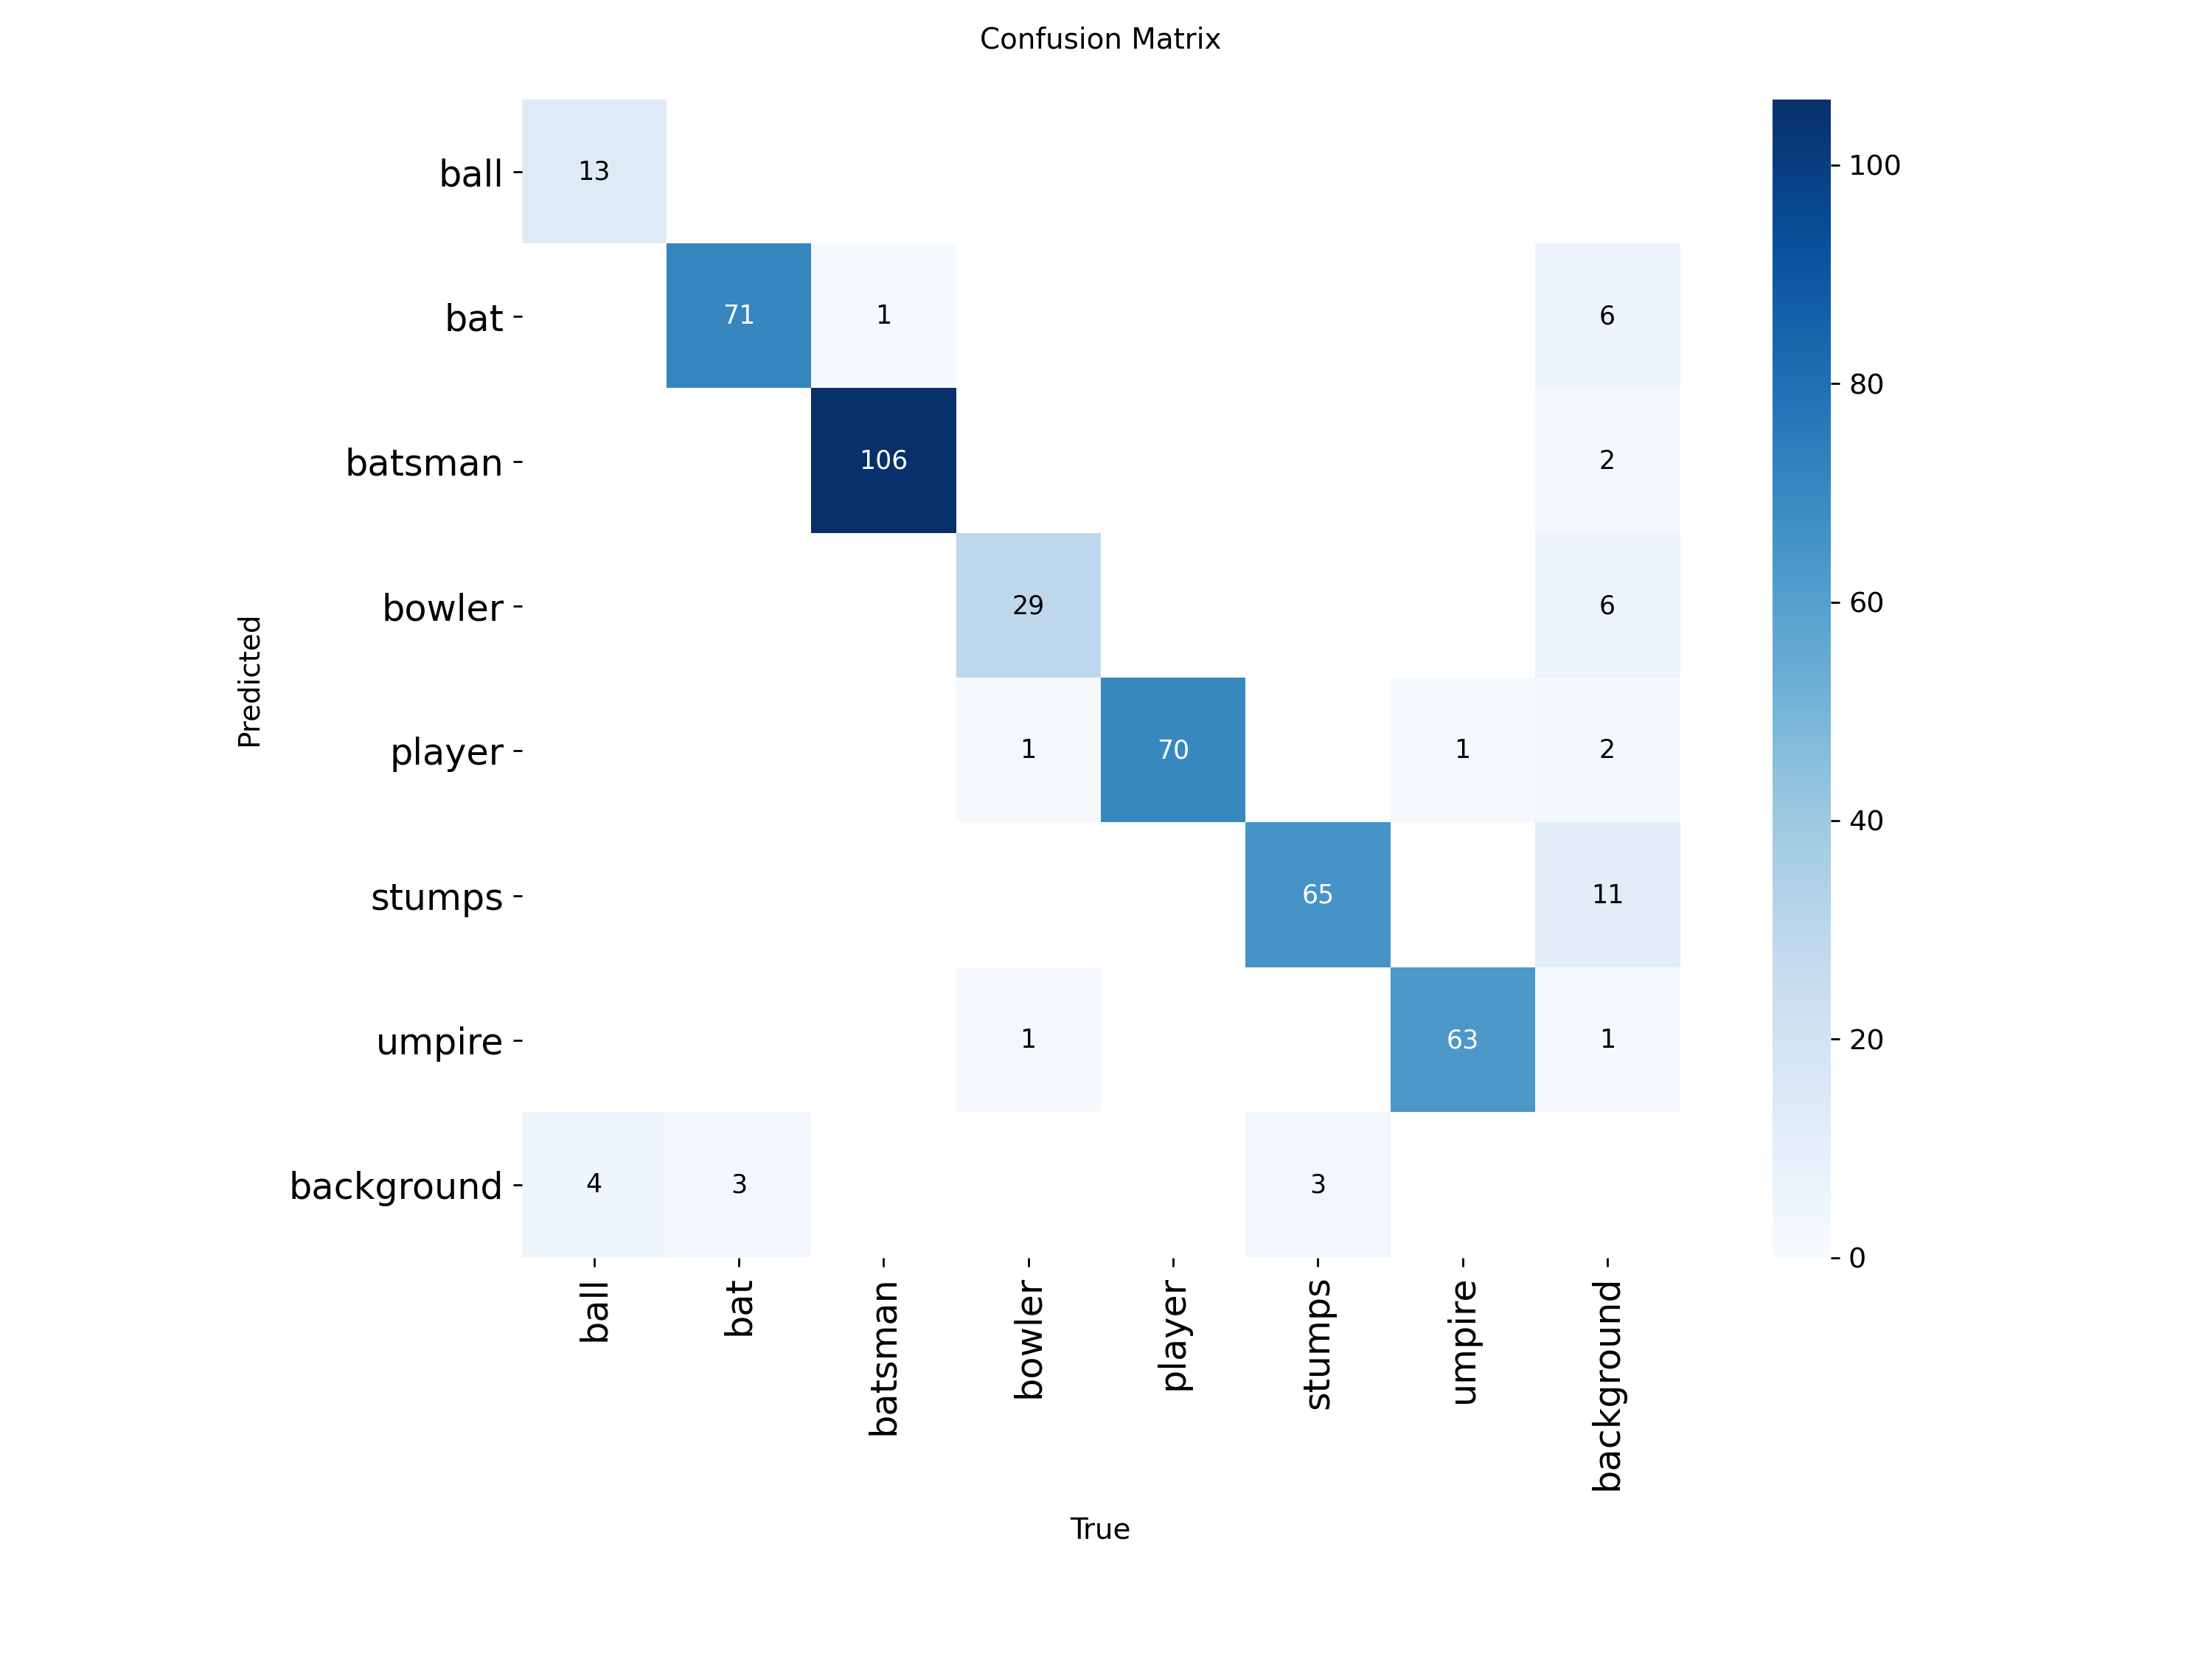

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

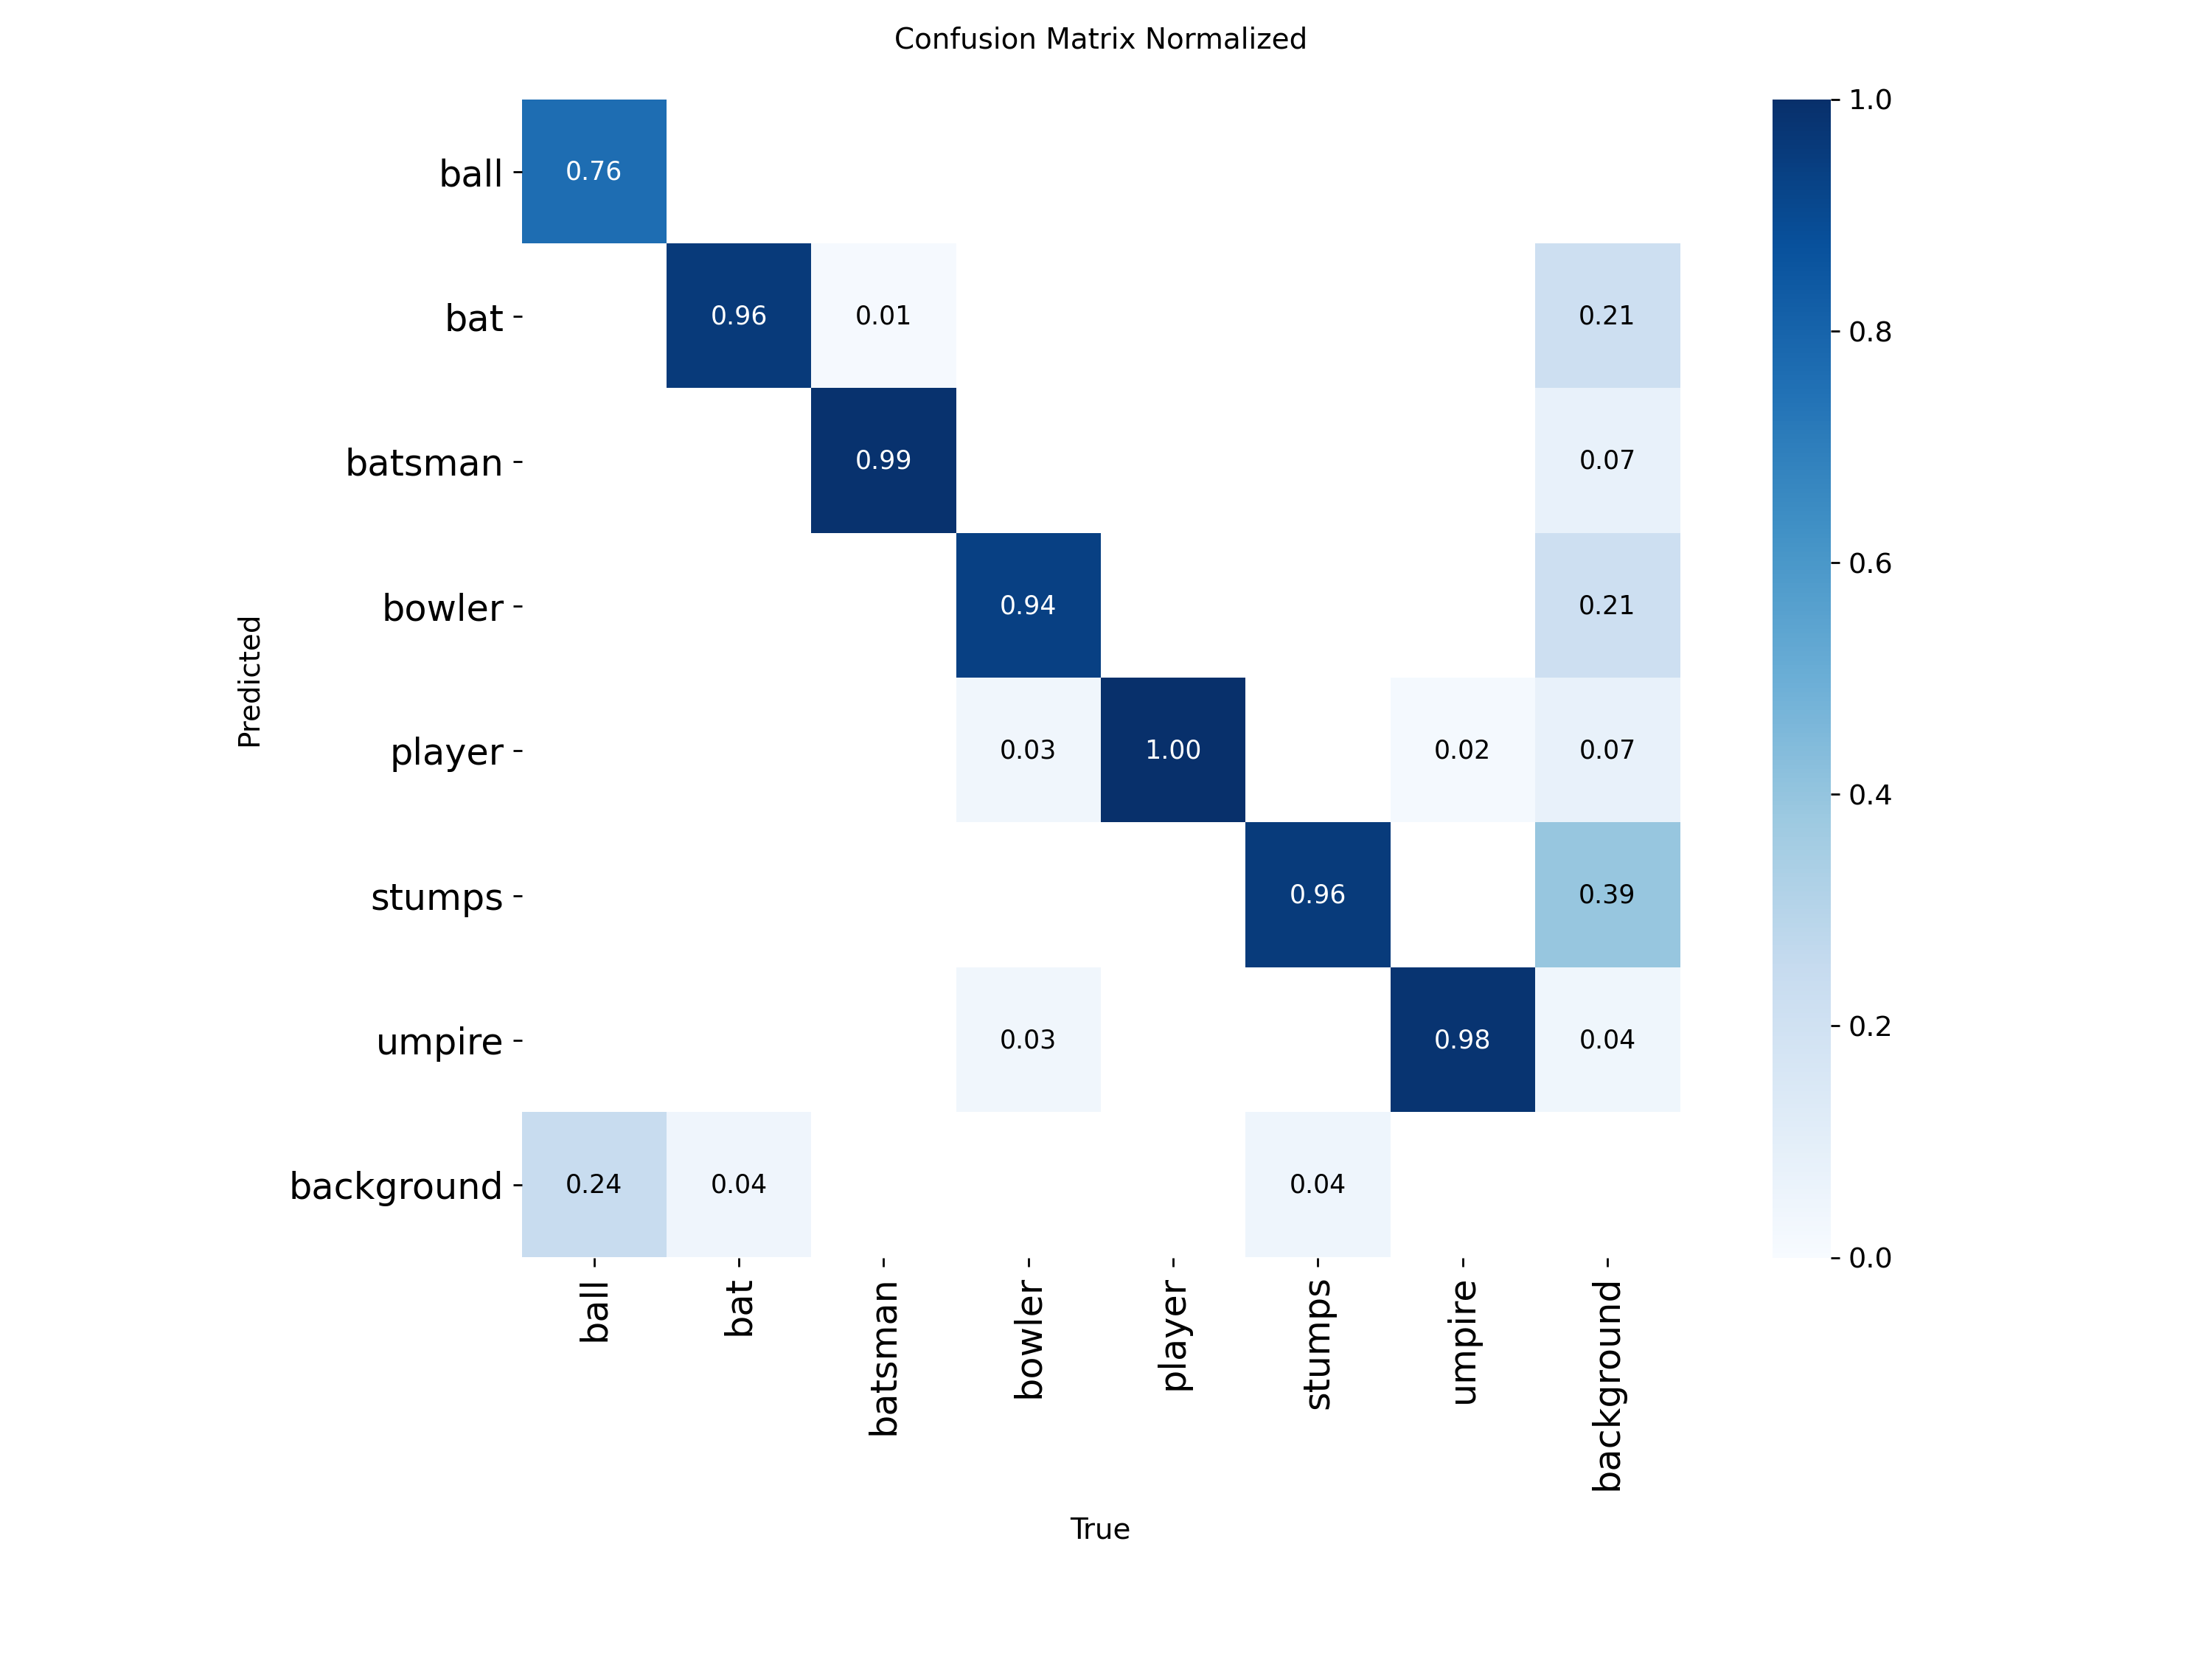

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix_normalized.png', width=600)

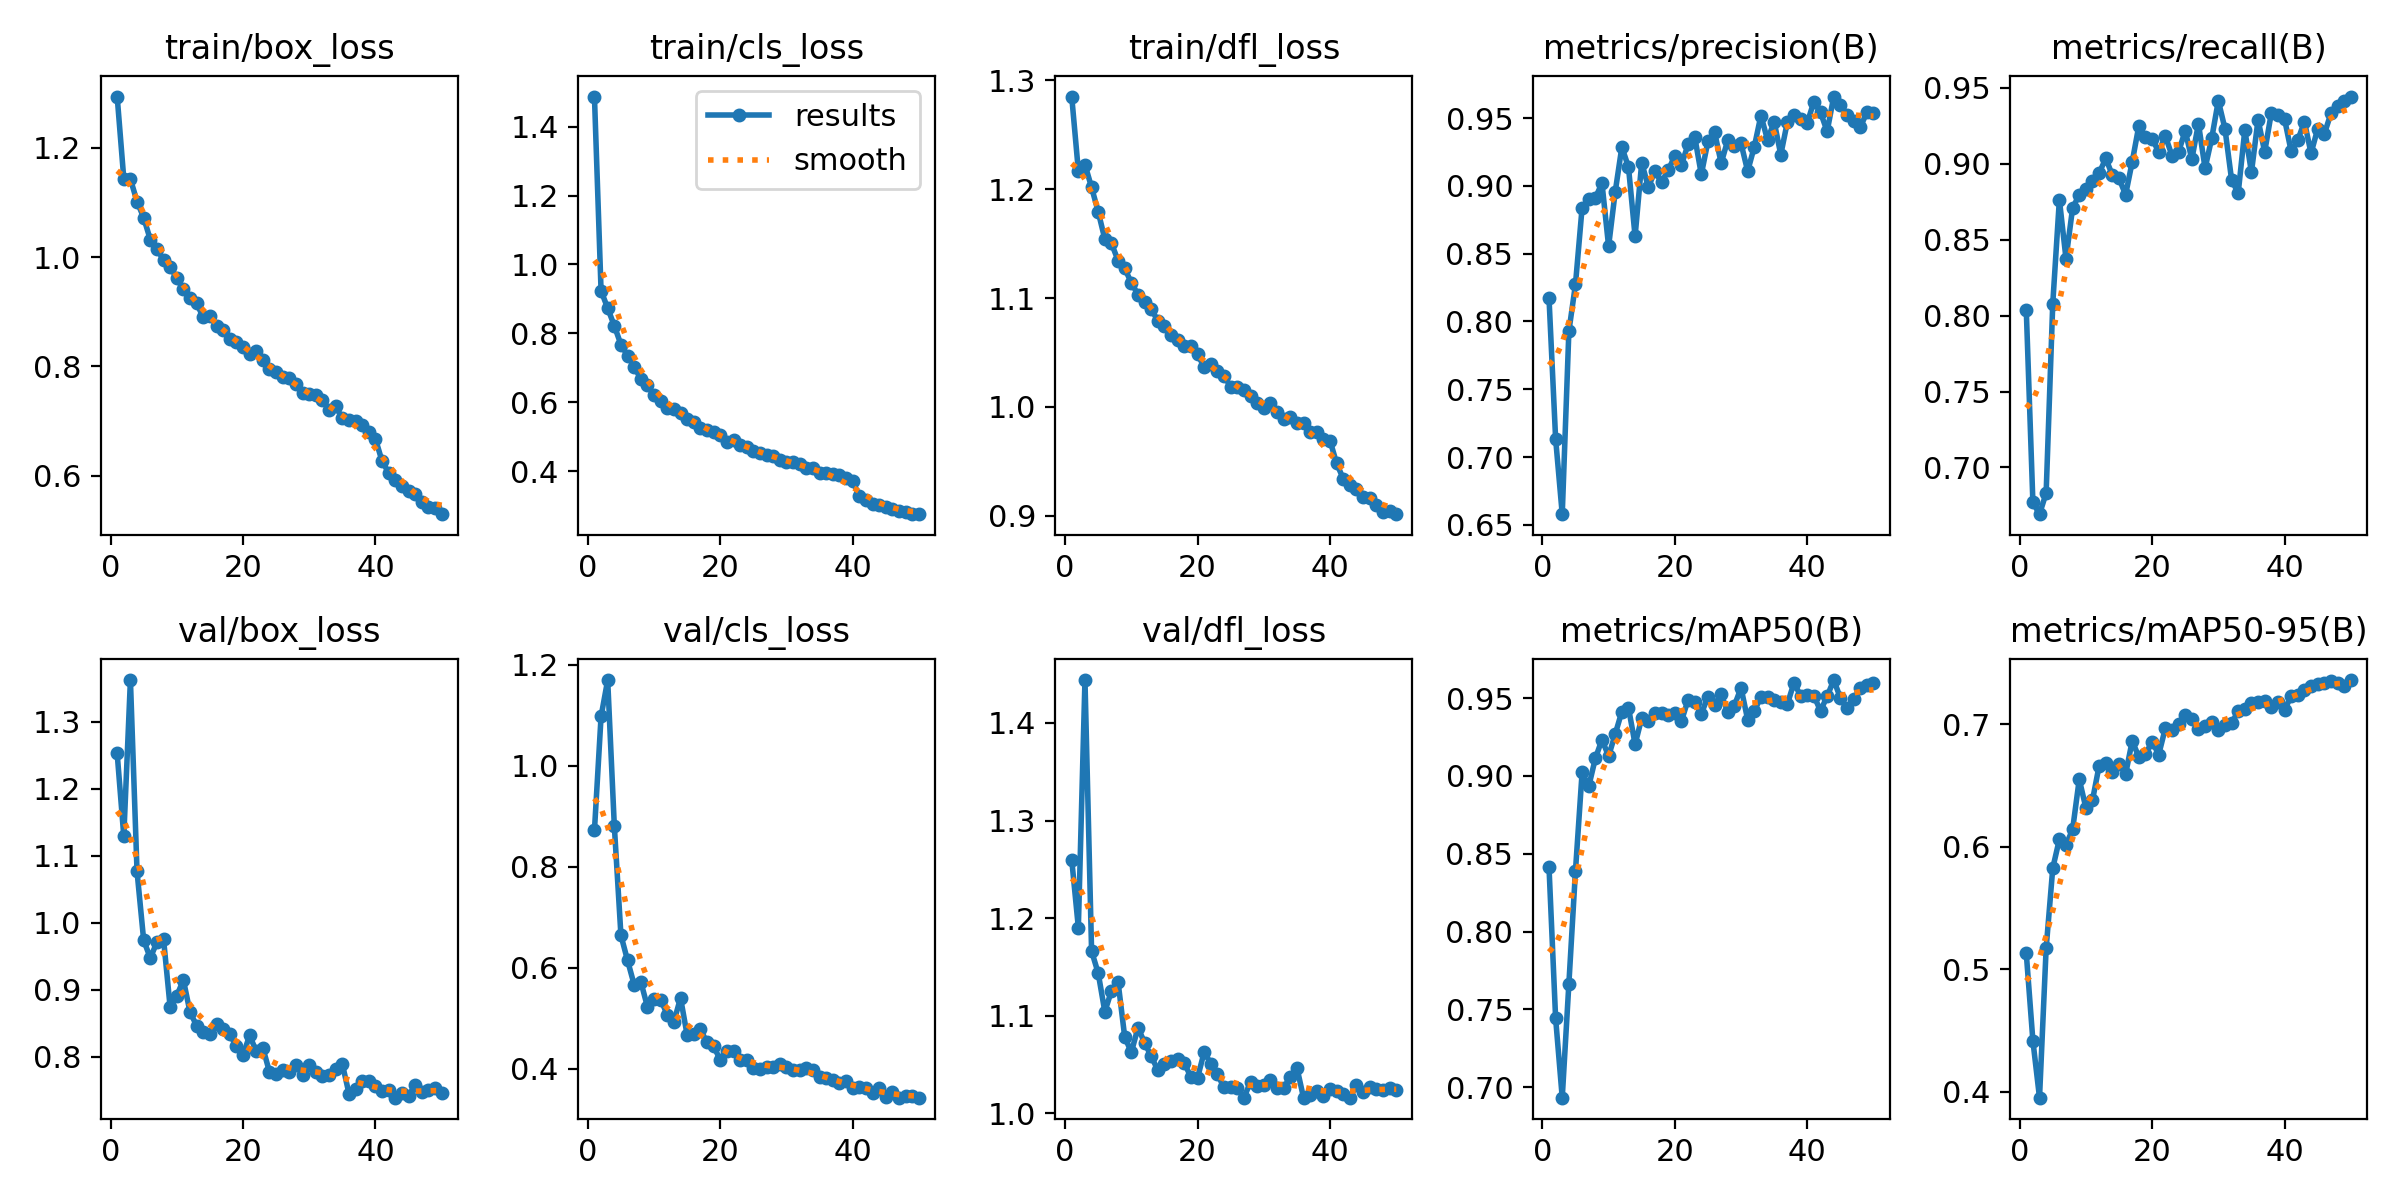

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

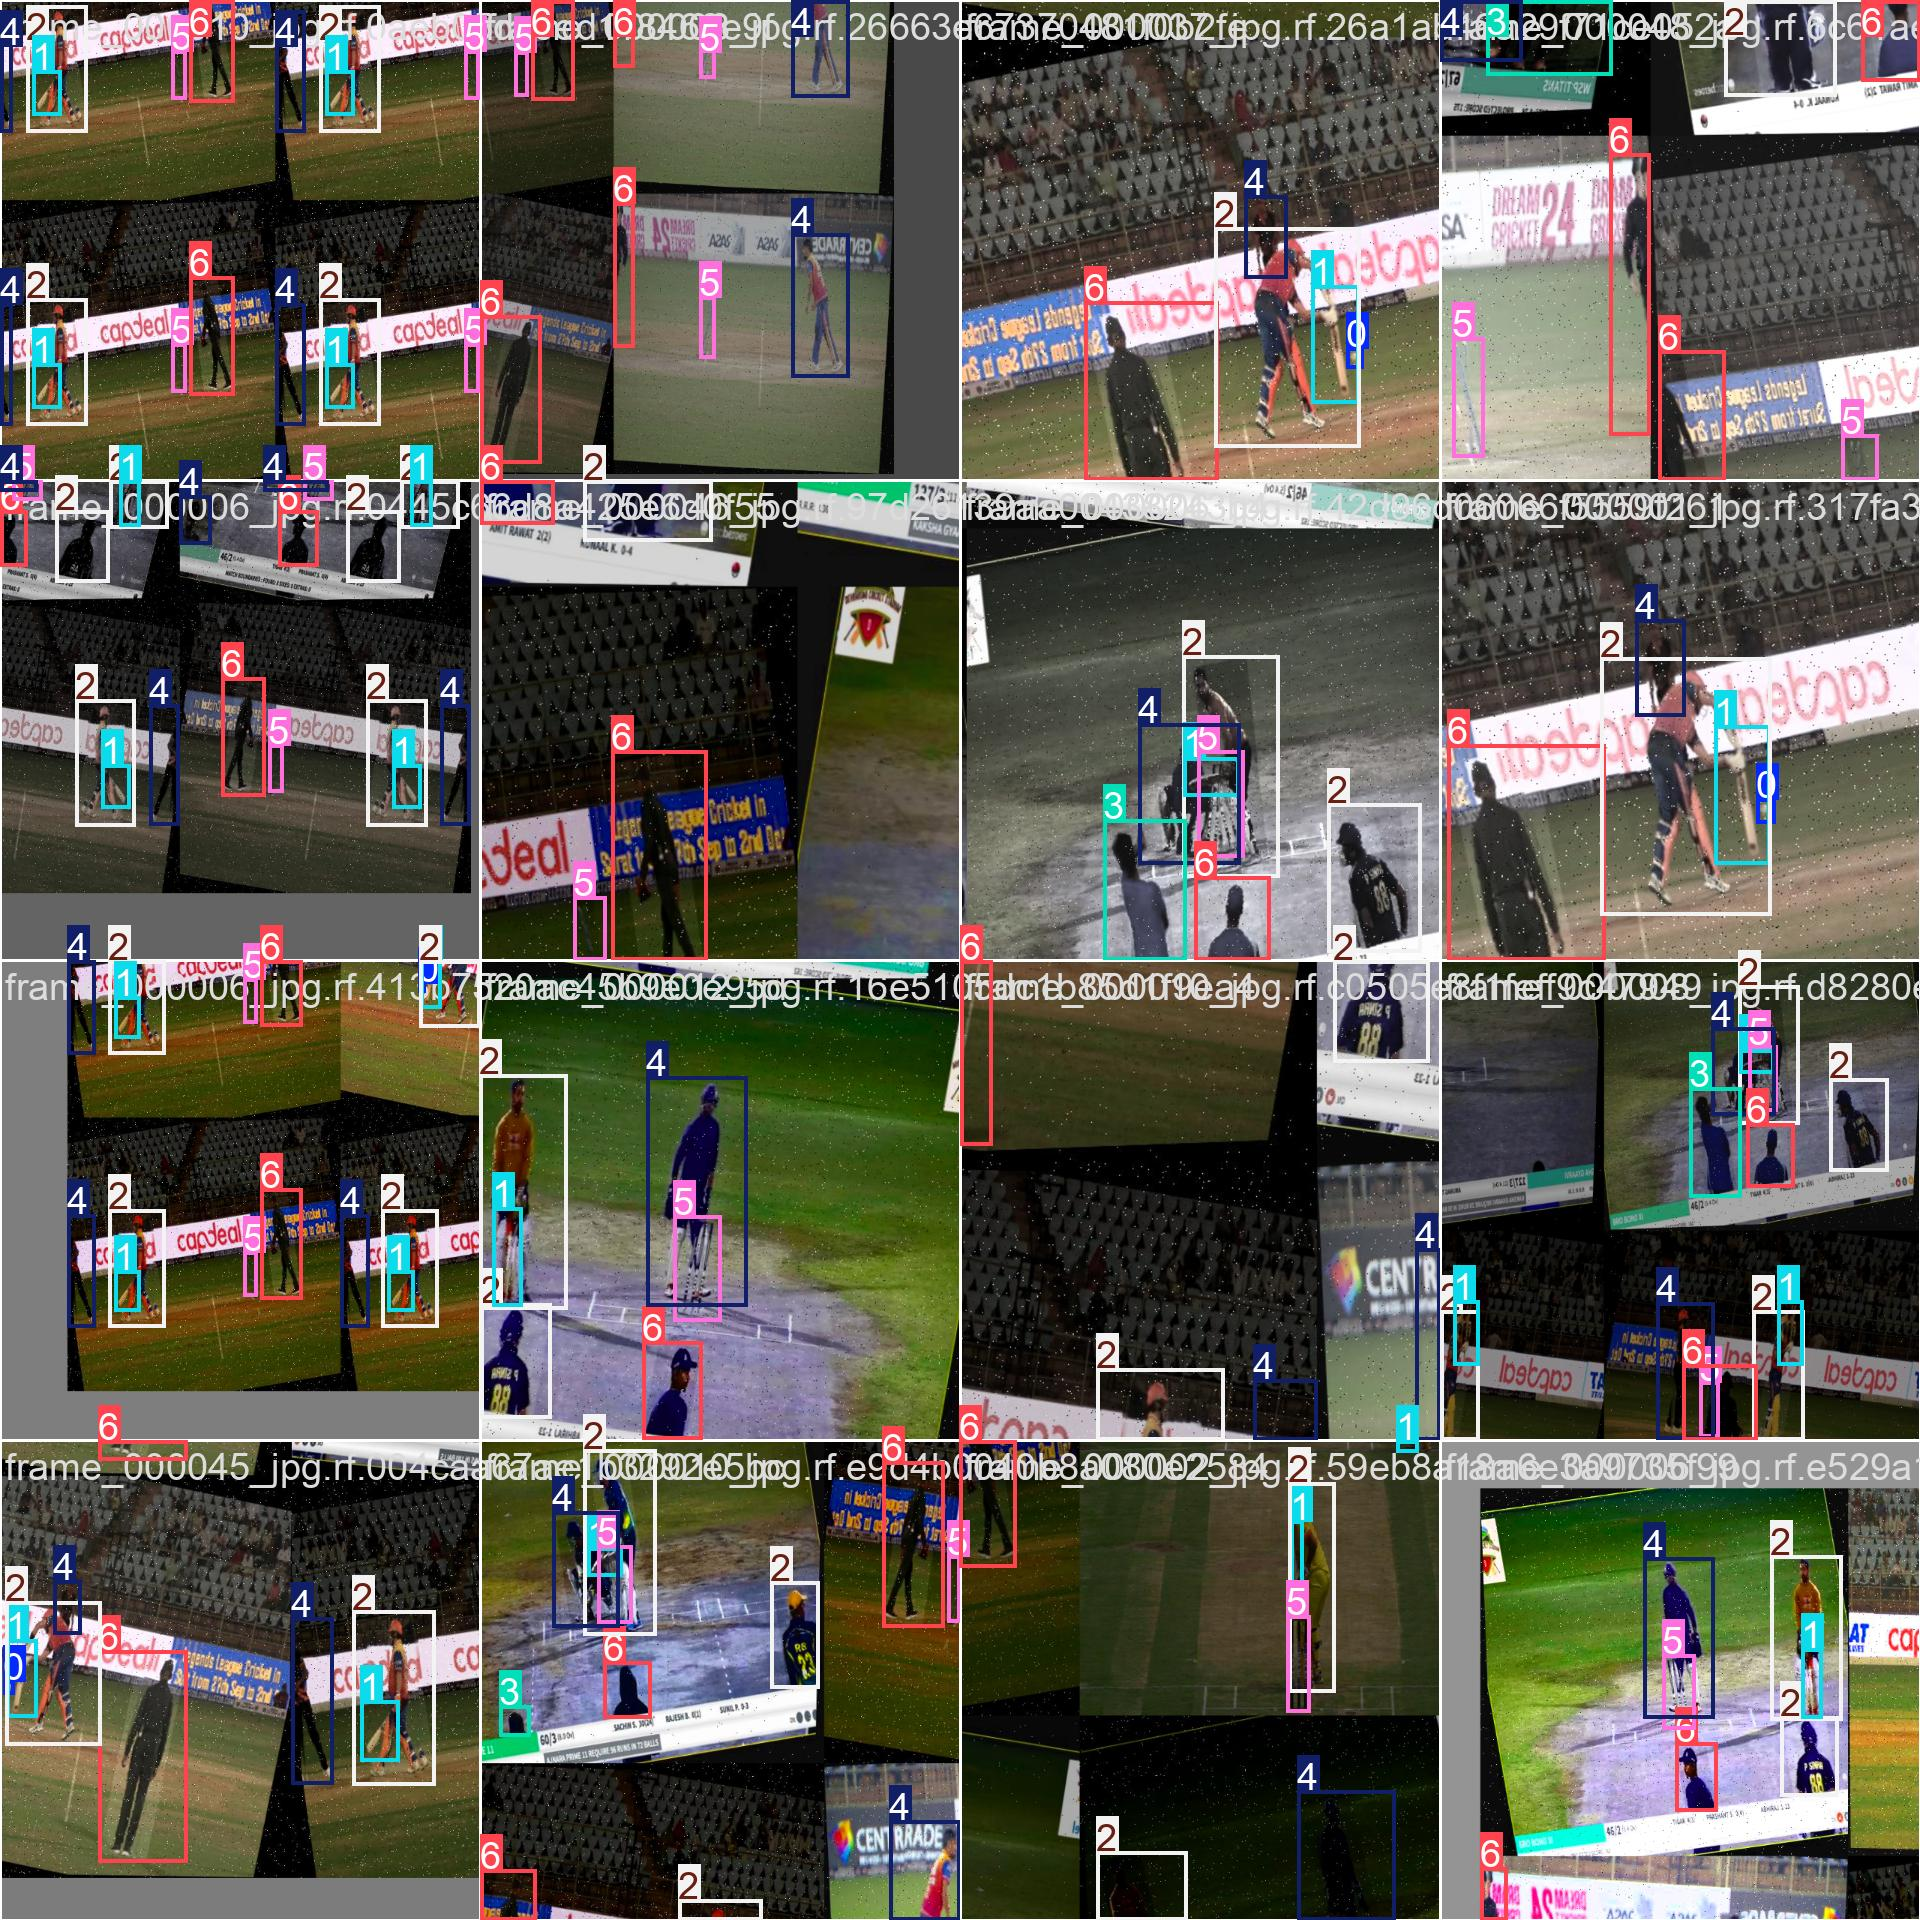

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/train_batch0.jpg', width=640)

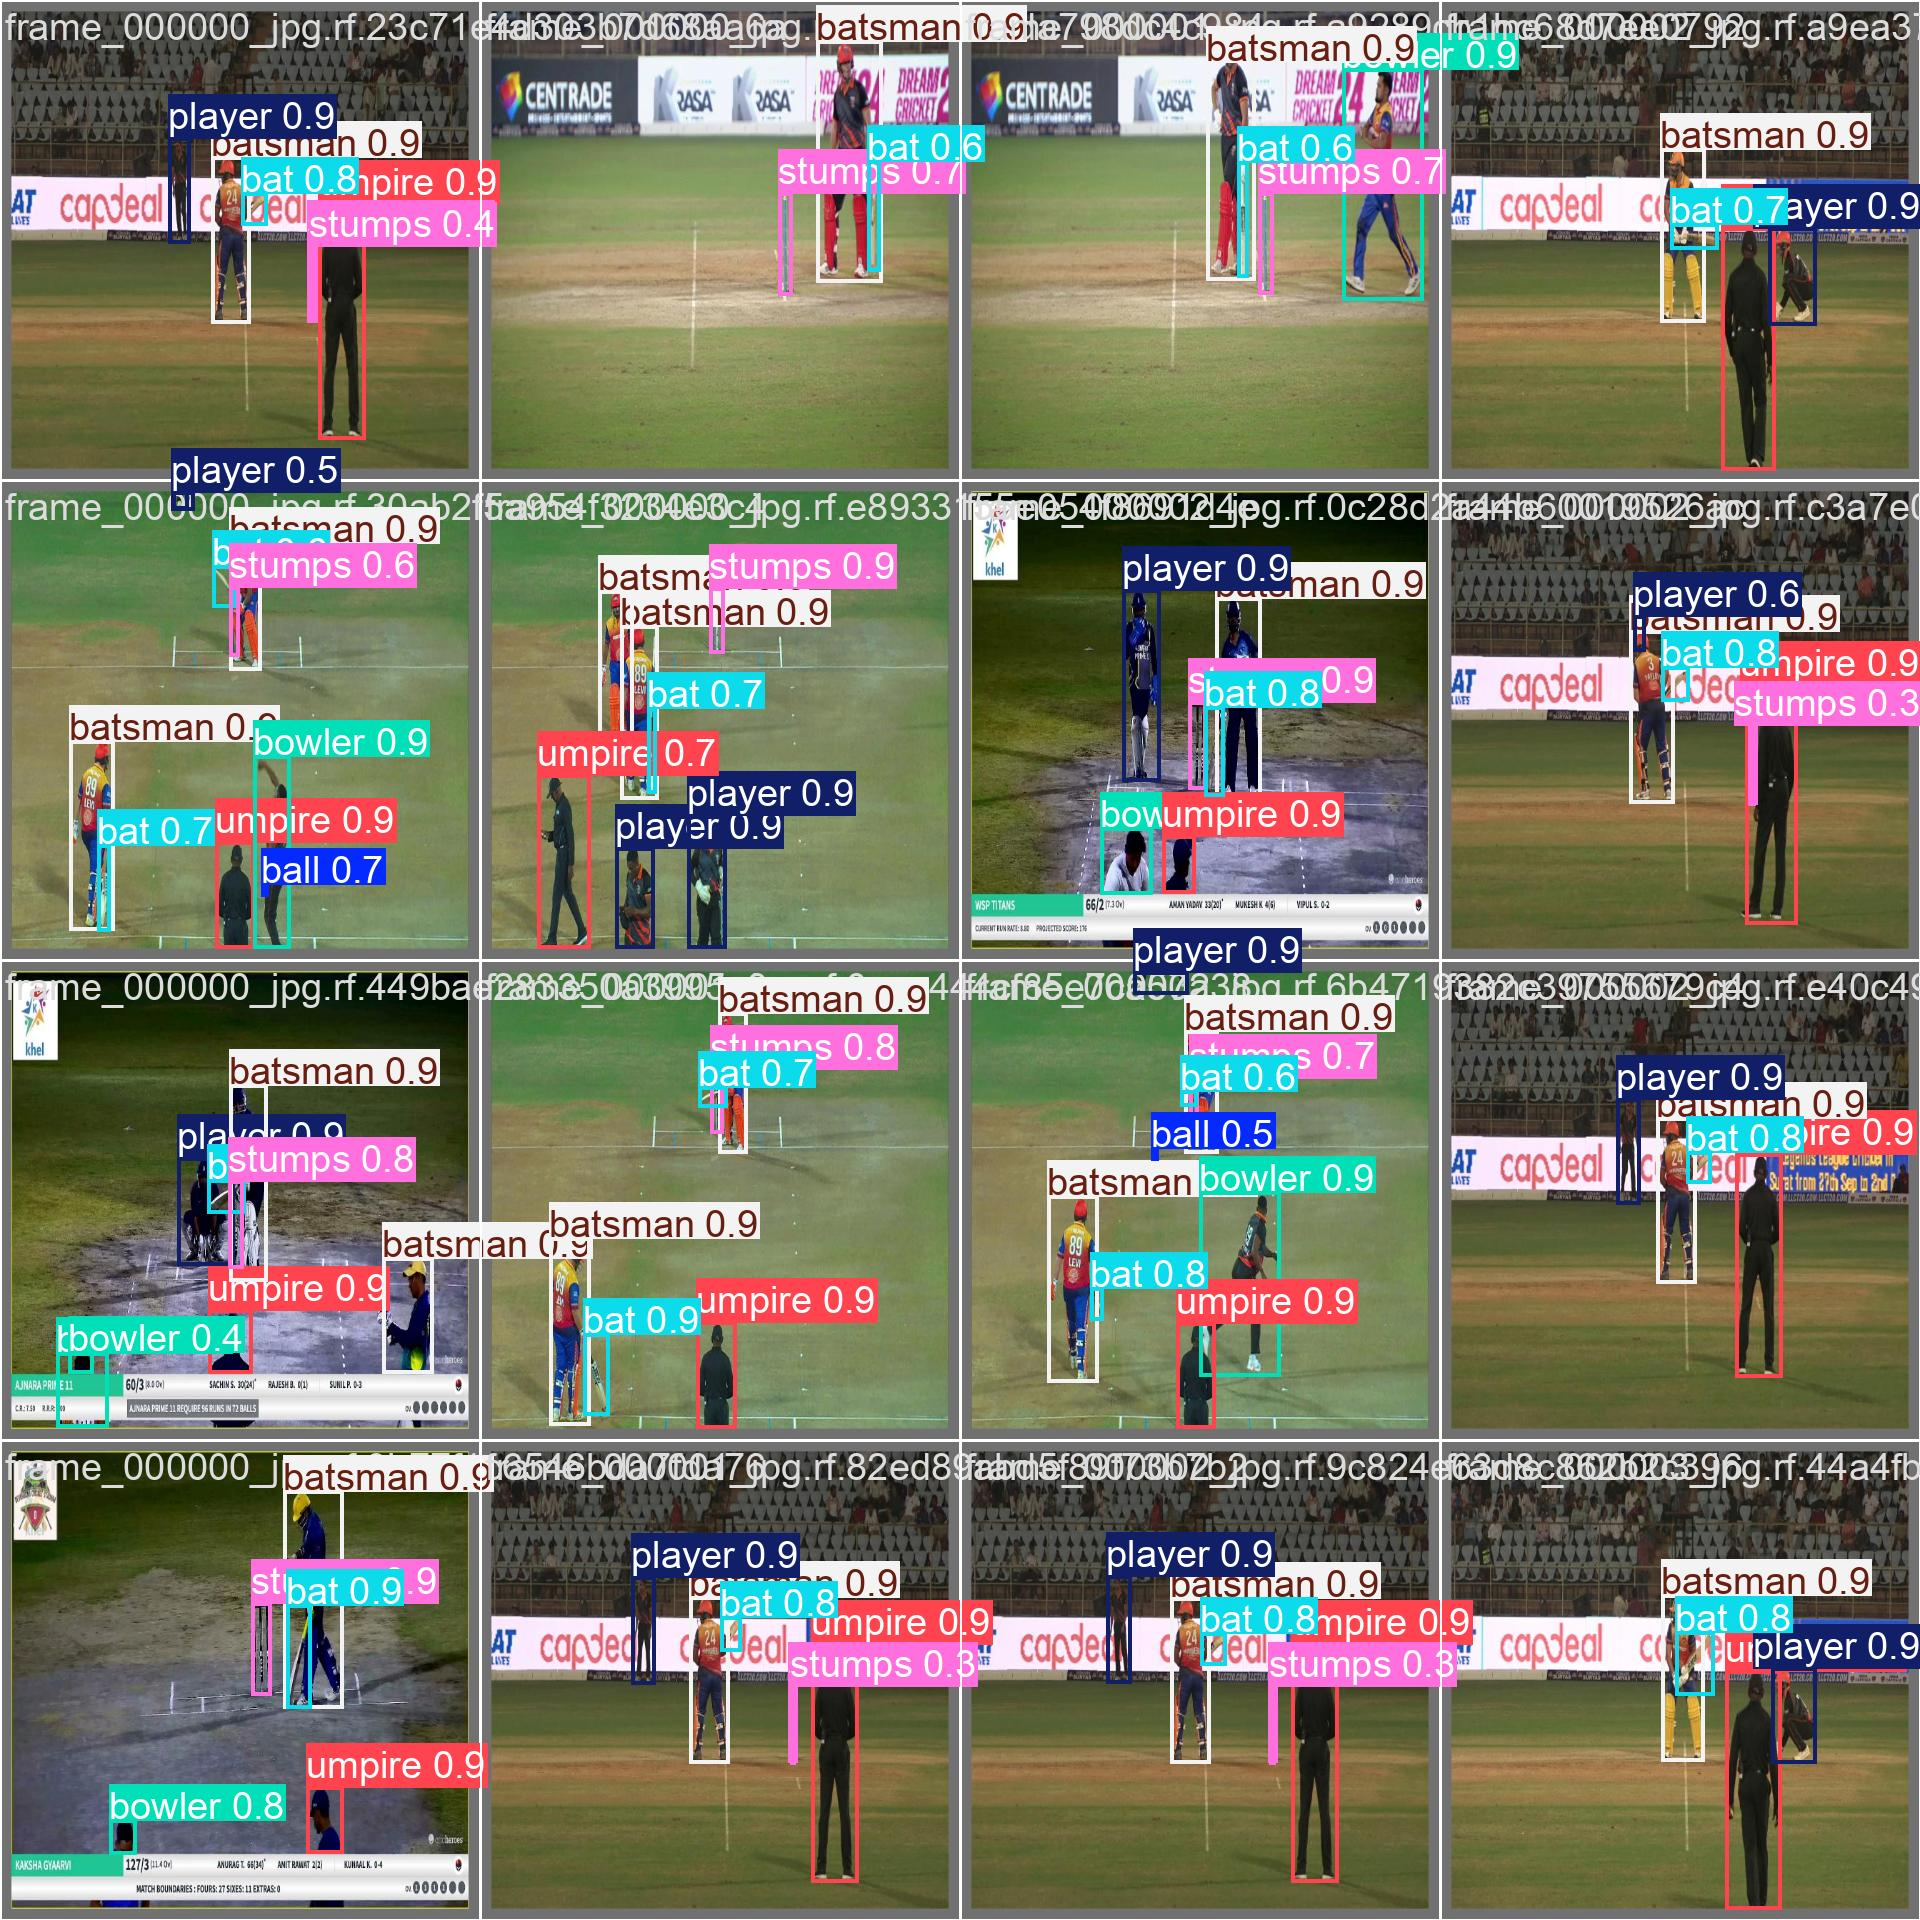

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=640)

## Validate fine-tuned model

In [ ]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.175 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,843,813 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1983.6±607.7 MB/s, size: 54.9 KB)
val: Scanning /content/datasets/cricket_object_detection-1/valid/labels.cache... 72 images, 0 backgrounds, 0 corrupt: 100% 72/72 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:03<00:00,  1.51it/s]
                   all         72        431      0.954      0.944       0.96      0.737
                  ball         17         17          1      0.756      0.852      0.372
                   bat         66         74      0.939      0.946      0.956      0.541
               batsman         71        107       0.99          1      0.995        0.9
                bowler         31         31       0.88      0.968      0.979      0.854
                player         58   

## Inference with custom model

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.50 source={dataset.location}/test/images save=True

Ultralytics 8.3.175 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,843,813 parameters, 0 gradients, 78.7 GFLOPs

image 1/51 /content/datasets/cricket_object_detection-1/test/images/frame_000000_jpg.rf.222e2186b52b6df071c5cad798478fa3.jpg: 640x640 1 bat, 1 batsman, 1 stumps, 37.0ms
image 2/51 /content/datasets/cricket_object_detection-1/test/images/frame_000000_jpg.rf.771b44b1890f7c150d9342a1d5672b47.jpg: 640x640 1 batsman, 2 players, 1 stumps, 1 umpire, 37.0ms
image 3/51 /content/datasets/cricket_object_detection-1/test/images/frame_000000_jpg.rf.9550300e6d08e2cc6785e9fdaaac8e05.jpg: 640x640 1 bat, 1 batsman, 1 stumps, 37.0ms
image 4/51 /content/datasets/cricket_object_detection-1/test/images/frame_000000_jpg.rf.ec7ae393f9434b0026affaa0d49c61a3.jpg: 640x640 1 bat, 1 batsman, 1 player, 1 stumps, 1 umpire, 36.9ms
image 5/51 /content/datasets/cricket_object_detection-1/test/images/frame_000001_jpg.rf.23976d6313584da70f85980a25d86b6e.jpg

**Let's take a look at few results.**

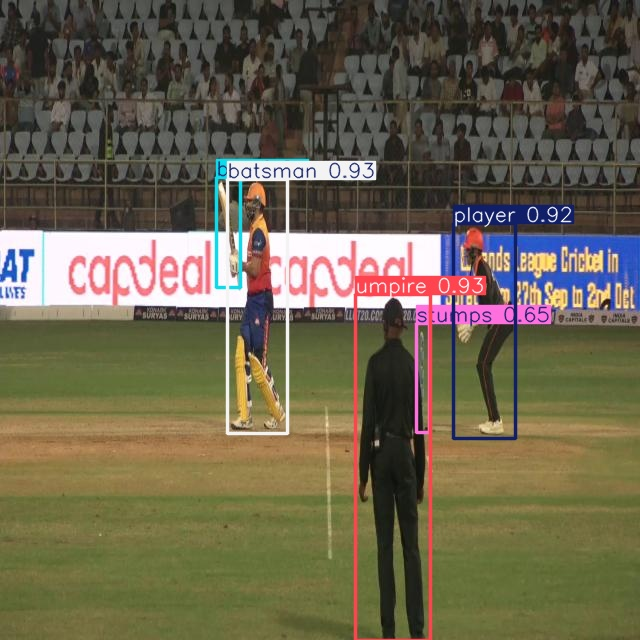

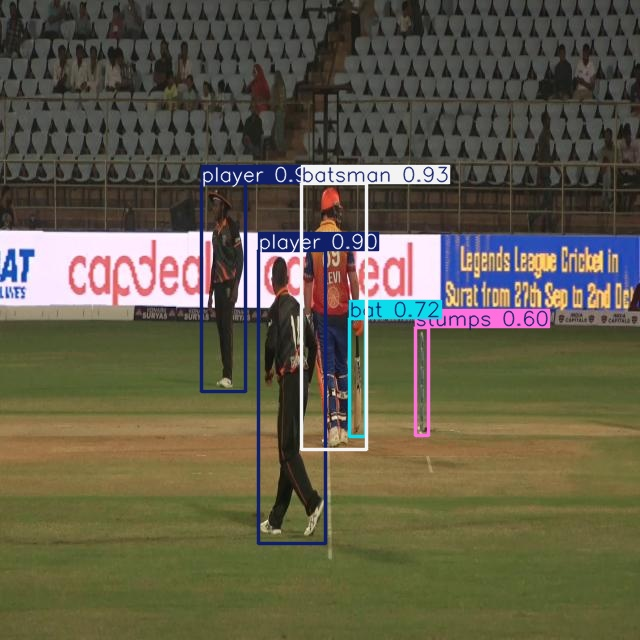

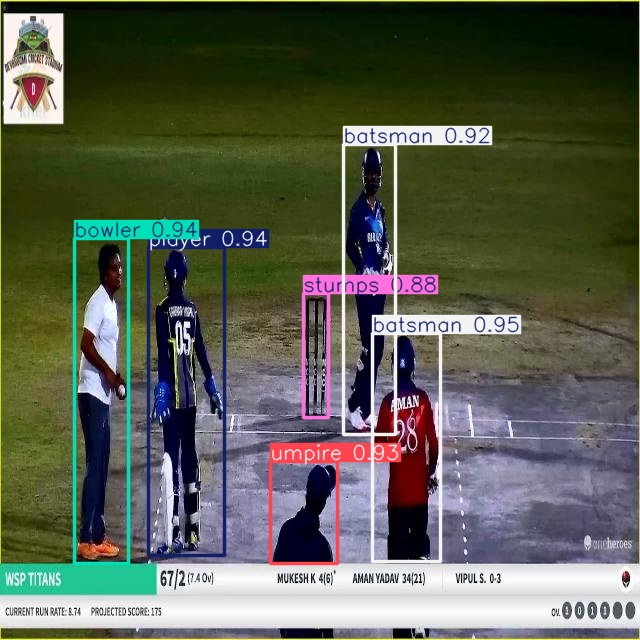

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

# Inference

Running inference on frame_000054_jpg.rf.968f86b645edb3baec1c93ca3398b021.jpg

0: 640x640 1 bat, 2 batsmans, 1 player, 1 stumps, 1 umpire, 37.0ms
Speed: 2.2ms preprocess, 37.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


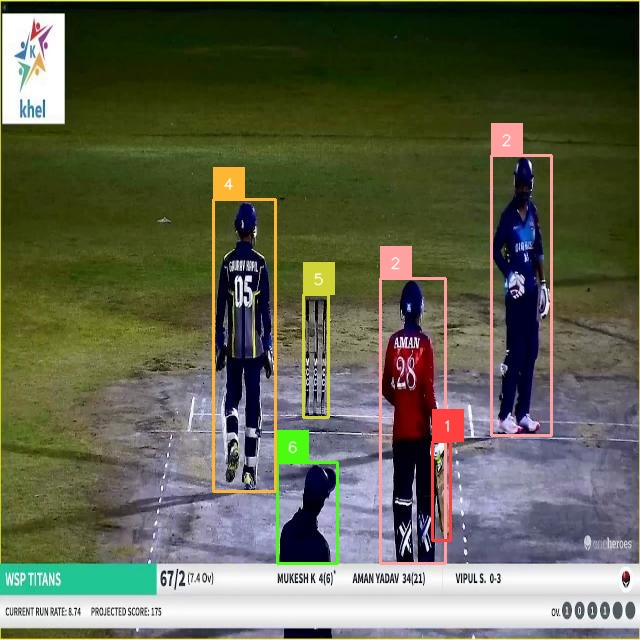

Running inference on frame_000002_jpg.rf.a478b0f3e0aebdd0772d7847570f61ee.jpg

0: 640x640 1 bat, 1 batsman, 1 bowler, 1 stumps, 35.3ms
Speed: 2.3ms preprocess, 35.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


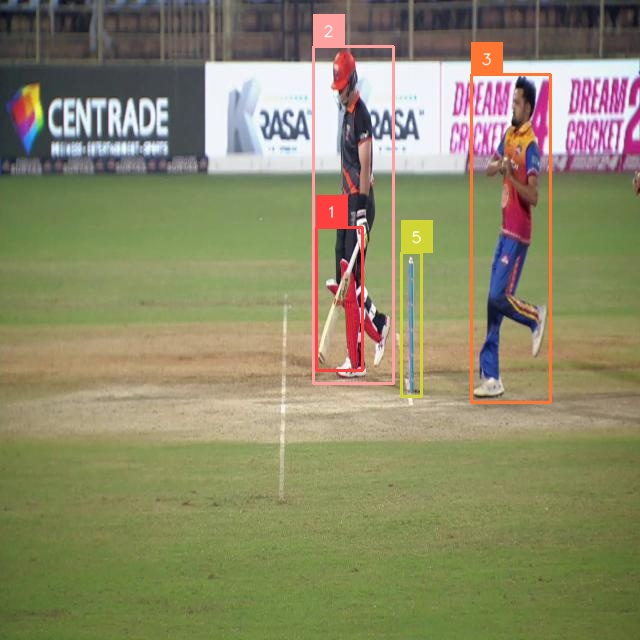

Running inference on frame_000024_jpg.rf.f282d2fe365b1b31e183affb9d8fbc2e.jpg

0: 640x640 1 bat, 2 batsmans, 1 bowler, 1 umpire, 29.5ms
Speed: 2.3ms preprocess, 29.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


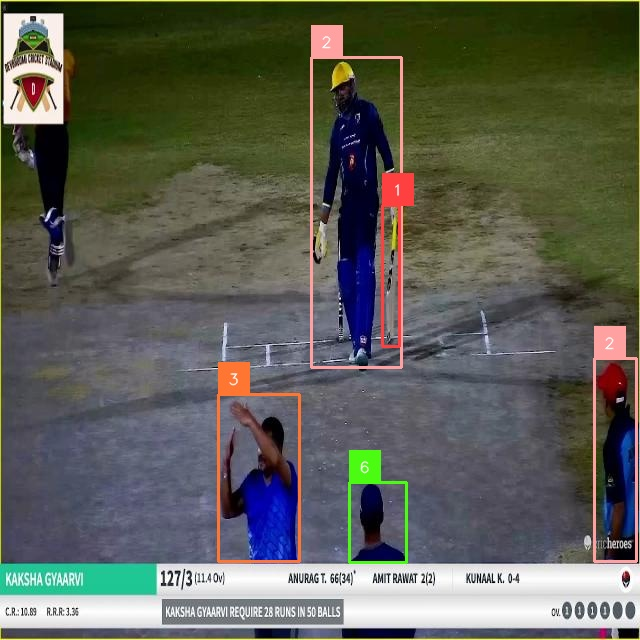

Running inference on frame_000035_jpg.rf.dca6f4fbbc2b1f4c349c4c126bced3ff.jpg

0: 640x640 1 ball, 1 bat, 1 batsman, 1 bowler, 1 player, 1 umpire, 29.5ms
Speed: 2.2ms preprocess, 29.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


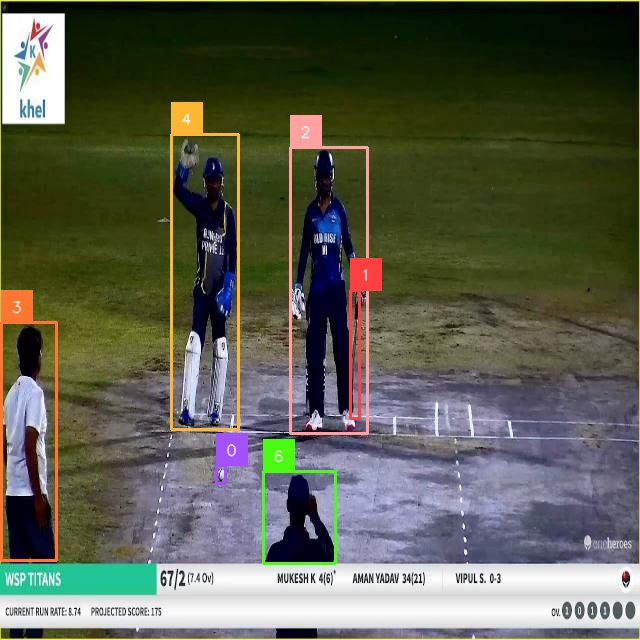

In [ ]:
import os
import random
import cv2
import supervision as sv
import IPython
from ultralytics import YOLO

# Load the custom model
model_loaded = YOLO('/content/runs/detect/train/weights/best.pt')

# Assuming 'dataset' is defined earlier with a 'location' attribute
# If not, replace this with the actual path to your test images
test_set_loc = dataset.location + "/test/images/"
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    print("Running inference on " + img_name)

    # Load image
    image_path = os.path.join(test_set_loc, img_name)
    image = cv2.imread(image_path)

    # Perform inference (note: method changed from .infer() to .predict())
    results = model_loaded(image, conf=0.4)[0]  # Confidence threshold set to 0.4

    # Convert results to Supervision Detections
    detections = sv.Detections(
        xyxy=results.boxes.xyxy.cpu().numpy(),
        confidence=results.boxes.conf.cpu().numpy(),
        class_id=results.boxes.cls.cpu().numpy().astype(int)
    )

    # Annotate boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display annotated image
    _, buffer = cv2.imencode('.jpg', annotated_image)
    i = IPython.display.Image(data=buffer)
    IPython.display.display(i)